In [2]:
import pandas as pd
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler
import math
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from matplotlib import pyplot
from numpy import concatenate

Using TensorFlow backend.


In [3]:
# load data
df = pd.read_csv("processed_data/drive4.csv", index_col=0)

In [4]:
df.head()

,x1,x2,y1,y2,object_type_Car,object_type_Van,static_dynamic_moving,static_dynamic_static,lat,lon,...,wu,pos_accuracy,vel_accuracy,navstat,numsats,posmode,velmode,orimode,Break,frame
0,181.47,201.45,425.60,464.04,1.0,0.0,0.0,1.0,48.959218,8.405842,...,-0.000932,0.073593,0.013454,4.0,10.0,5.0,5.0,6.0,False,0
1,181.47,201.45,425.63,464.06,1.0,0.0,0.0,1.0,48.959218,8.405842,...,-0.000328,0.073593,0.013454,4.0,10.0,5.0,5.0,6.0,False,1
2,181.47,201.45,425.65,464.09,1.0,0.0,0.0,1.0,48.959218,8.405842,...,-0.000487,0.073593,0.013454,4.0,10.0,5.0,5.0,6.0,True,2
3,181.47,201.45,425.68,464.12,1.0,0.0,0.0,1.0,48.959218,8.405842,...,0.001067,0.073593,0.013454,4.0,10.0,5.0,5.0,6.0,False,3
4,181.47,201.45,425.71,464.14,1.0,0.0,0.0,1.0,48.959218,8.405842,...,-0.000645,0.073593,0.013454,4.0,10.0,5.0,5.0,6.0,False,4


In [5]:
df.columns

Index(['x1', 'x2', 'y1', 'y2', 'object_type_Car', 'object_type_Van',
       'static_dynamic_moving', 'static_dynamic_static', 'lat', 'lon', 'alt',
       'roll', 'pitch', 'yaw', 'vn', 've', 'vf', 'vl', 'vu', 'ax', 'ay', 'az',
       'af', 'al', 'au', 'wx', 'wy', 'wz', 'wf', 'wl', 'wu', 'pos_accuracy',
       'vel_accuracy', 'navstat', 'numsats', 'posmode', 'velmode', 'orimode',
       'Break', 'frame'],
      dtype='object')

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# ensure all data is float
values = df.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[39]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.423815   0.005216   0.350058   0.348158        1.0        0.0   
2   0.423815   0.005216   0.350082   0.348175        1.0        0.0   
3   0.423815   0.005216   0.350099   0.348200        1.0        0.0   
4   0.423815   0.005216   0.350123   0.348225        1.0        0.0   
5   0.423815   0.005216   0.350148   0.348242        1.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...     var31(t)  var32(t)  \
1        0.0        1.0   0.992188    0.140625    ...     0.592710  0.890505   
2        0.0        1.0   0.992188    0.140625    ...     0.586710  0.890505   
3        0.0        1.0   0.992188    0.140625    ...     0.645229  0.890505   
4        0.0        1.0   0.992188    0.140625    ...     0.580791  0.890505   
5        0.0        1.0   0.992188    0.140625    ...     0.607166  0.879283   

   var33(t)  var34(t)  var35(t)  var36(t)  var37(t)  var38(t)  var39(t)  \
1  0.788125      

In [11]:
# split into train and test sets
values = reframed.values
n_train = math.ceil(len(values) * .8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(288, 1, 78) (288,) (71, 1, 78) (71,)


In [12]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 288 samples, validate on 71 samples
Epoch 1/50
0s - loss: 0.3357 - val_loss: 0.5283
Epoch 2/50
0s - loss: 0.2177 - val_loss: 0.3823
Epoch 3/50
0s - loss: 0.2259 - val_loss: 0.3117
Epoch 4/50
0s - loss: 0.2296 - val_loss: 0.2924
Epoch 5/50
0s - loss: 0.2185 - val_loss: 0.3080
Epoch 6/50
0s - loss: 0.1965 - val_loss: 0.3302
Epoch 7/50
0s - loss: 0.1745 - val_loss: 0.3330
Epoch 8/50
0s - loss: 0.1539 - val_loss: 0.3036
Epoch 9/50
0s - loss: 0.1344 - val_loss: 0.2574
Epoch 10/50
0s - loss: 0.1261 - val_loss: 0.2175
Epoch 11/50
0s - loss: 0.1208 - val_loss: 0.1929
Epoch 12/50
0s - loss: 0.1141 - val_loss: 0.1760
Epoch 13/50
0s - loss: 0.1067 - val_loss: 0.1599
Epoch 14/50
0s - loss: 0.0984 - val_loss: 0.1402
Epoch 15/50
0s - loss: 0.0906 - val_loss: 0.1193
Epoch 16/50
0s - loss: 0.0843 - val_loss: 0.1047
Epoch 17/50
0s - loss: 0.0806 - val_loss: 0.0987
Epoch 18/50
0s - loss: 0.0803 - val_loss: 0.1005
Epoch 19/50
0s - loss: 0.0790 - val_loss: 0.1049
Epoch 20/50
0s - loss: 0.0770 - v

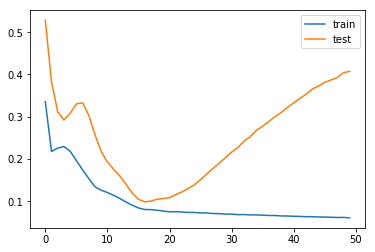

In [14]:
# plot RMSE
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()